# July 6th 
Today's Goal: See if it is possible for one to solve this problem unsupervised by first seperating Wake from NREM+REM and then seperating NREM and REM.
Note: All daily data+notes will now be written in IPython Notebooks.

For this, I will begin experimenting with subject 1032's data.  

In [142]:
%matplotlib inline
import load,processing,clustering,plotting
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
eeg1032,emg1032,actualStates1032=load.getData('../Data/channels1032.dat','../Data/teststates1032.dat')
features1032=processing.getFeatures(eeg1032,emg1032)

Reading Channels from file...
Done!
Reading test states from file...
Done!
Calculating features...


/Users/sreejan/Documents/Programming/SleepClassification/src/load.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a=channelArray[i:i+epochSize]


Done!
Normalizing features...
Done!


The features that seperate Wake the best are EMG Power, Large/Small Ratio (0.5-55 Hz power/0.5-22 Hz power), and number of sign inversions. This was determined by the Analysis of Variance tests done previously. 

In [143]:
seperateWake1032=features1032[:,2:5]
actualWake1032=[0 if i==0 else 1 for i in actualStates1032]


Calculating features plot...


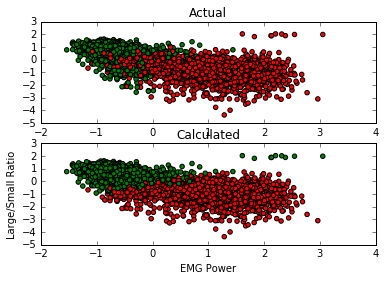

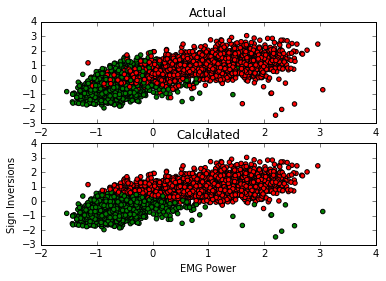

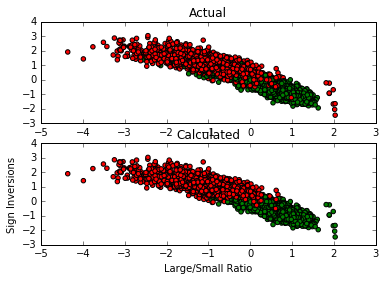

Done!


In [144]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=2)
kmeans.fit(seperateWake1032)
calcStates1032=kmeans.labels_
group0=[seperateWake1032[i][0] for i in range(len(calcStates1032)) if calcStates1032[i]==0]
group1=[seperateWake1032[i][0] for i in range(len(calcStates1032)) if calcStates1032[i]==1]
#if mean EMG power for wake is < mean EMG power for sleep, switch them.
if np.mean(group0)< np.mean(group1):
    calcStates1032=[0 if i==1 else 1 for i in calcStates1032[:]]

plotting.plotFeatures(seperateWake1032,calcStates1032,actualWake1032,['EMG Power','Large/Small Ratio','Sign Inversions'])

For coloring, I assumed Wake had average EMG Power greater than sleep (Wake=Red, Green=Sleep).The clustering looks very similar to the actual. It shows that wake can indeed be seperated without supervision.

Calculating features plot...


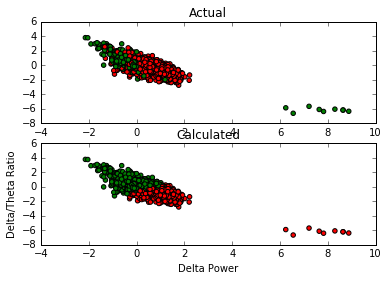

Done!


In [147]:
sleepIndices=[i for i in range(len(calcStates1032)) if calcStates1032[i]==1]
seperateSleep1032=[]
actualSleep1032=[]
for i in sleepIndices:
    seperateSleep1032.append(features1032[i][0:2])
    if actualStates1032[i]==1:
        actualSleep1032.append(0)
    else:
        actualSleep1032.append(1)

seperateSleep1032=np.asarray(seperateSleep1032)
actualSleep1032=np.asarray(actualSleep1032)

kmeans=KMeans(n_clusters=2)
kmeans.fit(seperateSleep1032)
calcStates1032=kmeans.labels_

group0=[seperateSleep1032[i][0] for i in range(len(calcStates1032)) if calcStates1032[i]==0]
group1=[seperateSleep1032[i][0] for i in range(len(calcStates1032)) if calcStates1032[i]==1]

#if mean Delta power for NREM is < mean Delta power for REM, switch them.
if np.mean(group0)< np.mean(group1):
    calcStates1032=[0 if i==1 else 1 for i in calcStates1032[:]]

plotting.plotFeatures(seperateSleep1032,calcStates1032,actualSleep1032,['Delta Power','Delta/Theta Ratio'])

    

From this plot (green=REM, red=NREM), it can be seen that NREM and REM are indeed able to be clustered accurately if we exclude calculated wake states and only use delta power and delta/theta ratios as features. 

In conclusion, an unsupervised method is indeed possible if I use a 2means cluster to seperate Wake and Sleep using EMG Power, Sign Inversions, and Large Wavelength/Small Wavelength Power ratio and another 2means cluster to seperate NREM and REM using Delta/Theta Power Ratio and Delta Power. I will implement a function that does this whole process. 

Calculating features plot...


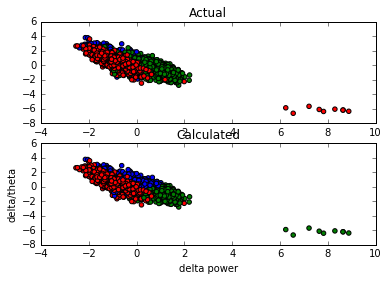

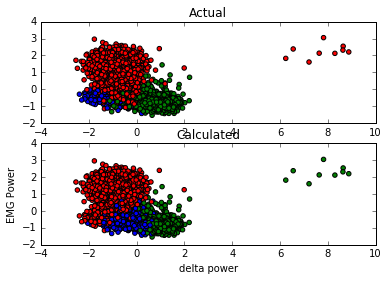

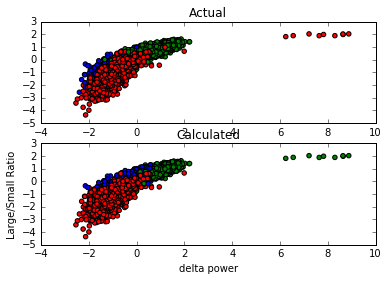

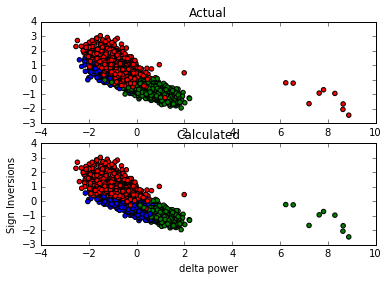

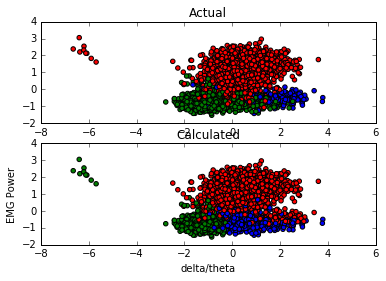

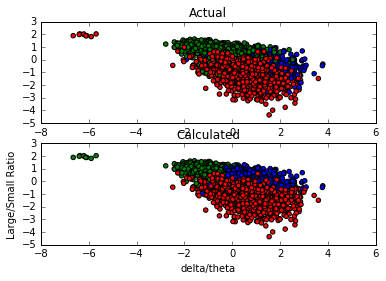

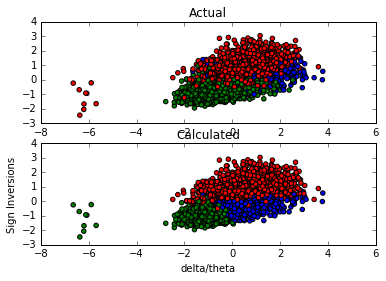

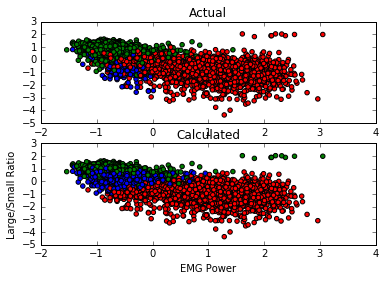

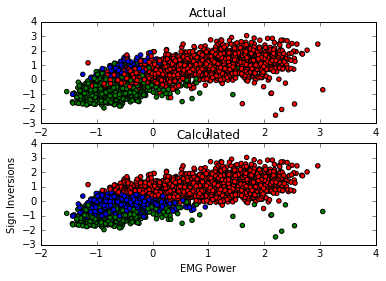

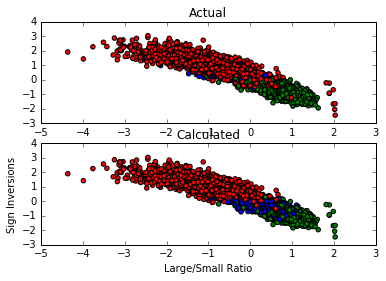

Done!


In [154]:
reload(clustering)
reload(plotting)
labels1032=clustering.doubleKmeansCluster(features1032)
plotting.plotFeatures(features1032,labels1032,actualStates1032,['delta power','delta/theta','EMG Power','Large/Small Ratio','Sign Inversions'])

This is the result of the double k-means classifying function when run on subject 1032's data. It hits some of the REM data, but it has some false positives as well. 

Classifier accuracy: 0.7428441617446615
REM Accuracy: 0.5175438596491229

Wake. Calculated 1766 with actual 1792
NREM. Calculated 1567 with actual 2382
REM. Calculated 1069 with actual 228


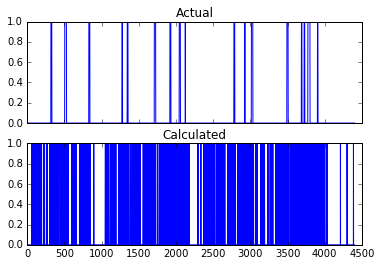

In [155]:
matches=0
remmatches=0
totalrem=0
for i in range(len(actualStates1032)):
    if actualStates1032[i]==2:
        totalrem+=1
    if actualStates1032[i]==labels1032[i]:
        matches+=1
        if labels1032[i]==2:
            remmatches+=1
    
acc=float(matches)/len(labels1032)
racc=float(remmatches)/totalrem
print("Classifier accuracy: {}".format(acc))
print("REM Accuracy: {}".format(racc))
print("")

clustering.printSimilarity(actualStates1032,labels1032)

plotting.plotREMHypnogram(actualStates1032,labels1032)

The problem here is that kmeans is assuming the size of each cluster should be about even, when in reality REM should be much less apparent. A different classifier, or a better feature for REM, is necessary.